In [1]:


# If `ordered` is `False`, do not sort `lst`
def median(lst,ordered=False):
	assert lst,"median needs a non-empty list"
	n = len(lst)
	p = q  = n//2
	if n < 3:
		p,q = 0, n-1
	else:
		lst = lst if ordered else sorted(lst)
		if not n % 2: # for even-length lists, use mean of mid 2 nums
			q = p -1
	return lst[p] if p==q else (lst[p]+lst[q])/2

class remedian:
	'''https://ttv1.github.io/remedian.html
	Copyright © 2016,2017 Tim Menzies tim@menzies.us, MIT license v2.'''

	# Initialization
	def __init__(i,inits=[], k=64):  # after some experimentation, 64 works ok
		i.all,i.k = [],k
		i.more,i._median=None,None
		[i + x for x in inits]

	 # When full, push the median of current values to next list, then reset.
	def __add__(i,x):
		i._median = None
		i.all.append(x)
		if len(i.all) == i.k:
			i.more = i.more or remedian(k=i.k)
			i.more + i._medianPrim(i.all)
			i.all = []  # reset

	#  If there is a next list, ask its median. Else, work it out locally.
	def median(i):
		return i.more.median() if i.more else i._medianPrim(i.all)

	# Only recompute median if we do not know it already.
	def _medianPrim(i,all):
		if i._median == None:
			i._median = median(all,ordered=False)
		return i._median

Mounted at /content/drive
            inflow_cfs  outflow_cfs  storage_af
1996-01-01      3470.0       2510.0    319648.0
1996-01-02      2695.0       2417.0    320184.0
1996-01-03      2932.0       2442.0    321136.0
1996-01-04      2563.0       2287.0    321671.0
1996-01-05      2380.0       2048.0    322326.0
...                ...          ...         ...
2023-12-27      1803.0       2034.0    464852.0
2023-12-28      2065.0       2214.0    464550.0
2023-12-29      1825.0       1972.0    464248.0
2023-12-30      2345.0       2002.0    464928.0
2023-12-31      1993.0       1911.0    465081.0

[10226 rows x 3 columns]


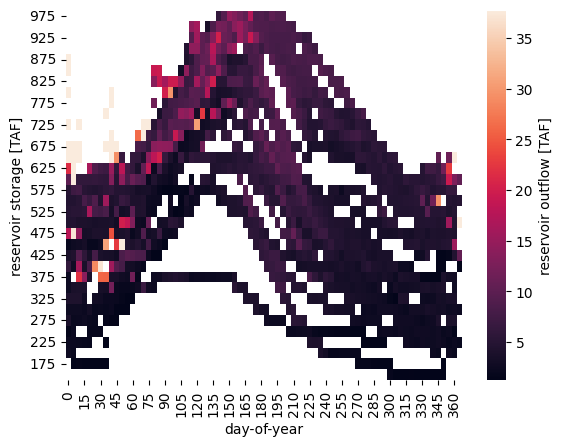

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

class folsom_medians():

  '''this class performs tabular (day-of-year,reservoir-storage) running median
  calculations to compute the scale of the folsom target reservoir release
  note: this could be tile-coded (http://www.incompleteideas.net/book/8/node6.html)
  ex: target = median_release(doy,res_stor) * e**(gaussian_neural_policy_output)'''

  def __init__(i, inits=[], k=64, stor_step=25, doy_step=5):
    i.K = 975 # folsom capacity [TAF]
    i.k = k # width of remedian lists
    i.cfs_to_taf = 2.29568411 * 10**-5 * 86400 / 1000
    i.stor_step = stor_step # discretization of storage vals
    i.doy_step = doy_step # discretization of day-of-year vals
    i.stor_bins = np.arange(0,i.K+i.stor_step,i.stor_step)
    i.doy_bins = np.arange(0,365+i.doy_step,i.doy_step)
    i.med_dict = {} # init. remedian objects store
    # ^ to be used with pd.DataFrame.from_dict(medians, orient='index')
    i.init_chart() # initialize release_dict with historical releases

  def init_chart(i):
    i.DIR = Path.cwd() / 'drive' / 'MyDrive'
    i.CDEC = i.DIR / 'folsim' / 'data' / 'cdec'
    i.hist_data = pd.read_csv(i.CDEC / 'fol_cdec_1996_2023.csv',index_col=0, infer_datetime_format=True, parse_dates=True)
    print(i.hist_data)
    i.hist_noleap = i.hist_data[~((i.hist_data.index.month == 2) & (i.hist_data.index.day == 29))] # could use these too
    hist_stor_disc = np.digitize(i.hist_noleap.storage_af/1000.,i.stor_bins)
    hist_doy_disc = np.digitize(i.hist_noleap.index.dayofyear-1.,i.doy_bins)
    for doy_ind, stor_ind, release_val in zip(hist_doy_disc,hist_stor_disc,i.hist_noleap.outflow_cfs):
      if (doy_ind,stor_ind) not in i.med_dict:
        i.med_dict[(doy_ind,stor_ind)] = remedian(k=i.k)
      i.med_dict[(doy_ind,stor_ind)] + release_val*i.cfs_to_taf
    i.medians = pd.Series({k: v.median() for k, v in i.med_dict.items()}).unstack(fill_value=np.nan)
    i.medians = i.medians[i.medians.columns.sort_values(ascending=False)].transpose()
    i.medians.columns = i.doy_bins[i.medians.columns-1]
    i.medians.index = i.stor_bins[i.medians.index]

  # def update_chart(i,storage_val,doy_val,release_val):

  # def fetch_release(i,storage_val,doy_val):

  def pretty_print(i):
    ax = sns.heatmap(i.medians,robust=True,)
    ax.set(xlabel="day-of-year", ylabel="reservoir storage [TAF]")
    ax.collections[0].colorbar.set_label("reservoir outflow [TAF]")
    plt.show()

fol = folsom_medians()
fol.pretty_print()